# 🎛️ CrimeLens — Interactive GNN Interface (Notebook 3)

This notebook connects the trained **GraphSAGE model** to an interactive explorer for entities extracted from *True Stories of Crime from the District Attorney’s Office*.

**Objectives**
1. Rebuild the transcript co-occurrence graph and node features (same as Notebook 2).  
2. Load the trained **GraphSAGE** weights and hyperparameters.  
3. Compute node embeddings and expose helper functions for:  
   - nearest-neighbor entities,  
   - link score between two entities,  
   - drawing a small neighborhood subgraph.  
4. Save artifacts (CSV / PNG) for the report and prepare for `ui/app.py`.

In [1]:
import os, re, itertools, json
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity

# Try PyG for SAGEConv (used in training)
from torch_geometric.nn import SAGEConv

# Paths (mirror your layout)
ROOT = Path.cwd()
if ROOT.name == "notebooks":
    DATA_DIR   = ROOT / "data"
    MODELS_DIR = ROOT.parent / "models"
    RESULTS    = ROOT.parent / "results"
else:
    DATA_DIR   = ROOT / "notebooks" / "data"
    MODELS_DIR = ROOT / "models"
    RESULTS    = ROOT / "results"

RESULTS.mkdir(exist_ok=True, parents=True)

print("DATA_DIR   =", DATA_DIR)
print("MODELS_DIR =", MODELS_DIR)
print("RESULTS    =", RESULTS)

/opt/anaconda3/envs/aml2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DATA_DIR   = /Users/rohitbogulla/Desktop/Sem 3/Applied ML 2/CrimeLens/notebooks/notebooks/data
MODELS_DIR = /Users/rohitbogulla/Desktop/Sem 3/Applied ML 2/CrimeLens/notebooks/models
RESULTS    = /Users/rohitbogulla/Desktop/Sem 3/Applied ML 2/CrimeLens/notebooks/results


## 1️⃣ Load Transcript and Rebuild Graph

Replicates tokenization & graph construction from Notebook 2 so feature space matches training.

In [2]:
# Load transcript (full → fallback)
full_csv   = DATA_DIR / "true_stories_transcript.csv"
sample_csv = DATA_DIR / "sample_transcripts.csv"

if full_csv.exists():
    df = pd.read_csv(full_csv)
    src = full_csv.name
else:
    df = pd.read_csv(sample_csv)
    src = sample_csv.name

print(f"Loaded {len(df)} rows from {src}")

# --- token extraction (identical to Notebook-2) ---
STOP = set("""
THE A AN AND OF IN ON TO BY FOR WITH FROM THIS THAT THOSE THESE IS ARE WAS WERE IT ITS AS AT OR
""".split())

KEY_TERMS = {
    "suspect","witness","police","bank","check","forgery","detective","evidence","room","object",
    "parker","mabel","peabody","jury","arrest","signature","certificate","money","crime","trial","court"
}

def extract_tokens(text):
    toks = re.findall(r"[A-Za-z][A-Za-z\-']{2,}", str(text))
    keep = []
    for t in toks:
        if t.upper() == t and len(t) > 3:
            continue
        if t[0].isupper() and t.upper() not in STOP:
            keep.append(t.lower())
        elif t.lower() in KEY_TERMS:
            keep.append(t.lower())
    return keep

df["tokens"] = df["text"].astype(str).map(extract_tokens)

# --- co-occurrence graph over sliding window ---
window = 5
from collections import Counter
co_counts = Counter()
for i in range(len(df)):
    bag = set(itertools.chain.from_iterable(df.loc[i:min(i+window, len(df)-1), "tokens"].values))
    for a, b in itertools.combinations(sorted(bag), 2):
        co_counts[(a,b)] += 1

min_co = 2
edges = [(a,b,w) for (a,b),w in co_counts.items() if w >= min_co]

G = nx.Graph()
for a,b,w in edges:
    G.add_edge(a,b,weight=w)

# keep giant component
if G.number_of_nodes() > 0:
    comps = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(comps[0]).copy()

nodes = sorted(G.nodes())
nid = {n:i for i,n in enumerate(nodes)}

print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Loaded 189 rows from true_stories_transcript.csv
Graph: 185 nodes, 3421 edges


## 2️⃣ Recreate Node Features

Feature layout used in training:  
**[ one-hot(type) | degree_z | term freq ]** with types = {person, role, artifact, other}.

In [3]:
def node_type(tok):
    if tok in {"mabel","parker","peabody","clark","lang","sweeney","patrick","mcmahon"}:
        return "person"
    if tok in {"suspect","witness","detective","jury","prisoner"}:
        return "role"
    if tok in {"bank","room","object","check","evidence","signature","court","money"}:
        return "artifact"
    return "other"

types = [node_type(n) for n in nodes]
type_vocab = sorted(set(types))
t2i = {t:i for i,t in enumerate(type_vocab)}

deg = np.array([G.degree(n) for n in nodes], dtype=float)
deg_norm = (deg - deg.mean()) / (deg.std() + 1e-9)

freq = Counter(itertools.chain.from_iterable(df["tokens"]))
tf = np.array([freq[n] for n in nodes], dtype=float)
tf = tf / (tf.max() + 1e-9)

X = np.zeros((len(nodes), len(type_vocab)+2), dtype=np.float32)
for i, t in enumerate(types):
    X[i, t2i[t]] = 1.0
X[:, len(type_vocab)]   = deg_norm
X[:, len(type_vocab)+1] = tf

in_dim = X.shape[1]
print("Feature matrix:", X.shape, "| type_vocab:", type_vocab)

Feature matrix: (185, 6) | type_vocab: ['artifact', 'other', 'person', 'role']


## 3️⃣ Define GraphSAGE and Load Weights

Reads `meta.json` (if present) for hyperparameters, then loads `gnn_model.pt`.  
Ensures hidden size and input dimension match training to avoid state-dict errors.

In [4]:
# Read meta if available
meta_path = MODELS_DIR / "meta.json"
meta = {}
if meta_path.exists():
    try:
        meta = json.loads(meta_path.read_text())
        print("Loaded meta:", meta)
    except Exception as e:
        print("Couldn't read meta.json:", e)

hidden_dim = int(meta.get("hidden_channels", 64))
# If meta contains in_channels and it differs, we warn and adapt only if shapes allow
meta_in = meta.get("in_channels", None)
if meta_in is not None and meta_in != in_dim:
    print(f"⚠️ Warning: current in_dim={in_dim} differs from meta.in_channels={meta_in}. "
          f"Rebuilding features matched training is recommended. Continuing with in_dim={in_dim}.")

class GraphSAGE(nn.Module):
    def __init__(self, in_dim, h):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, h)
        self.conv2 = SAGEConv(h, h)
        self.scorer = nn.Sequential(nn.Linear(2*h, h), nn.ReLU(), nn.Linear(h, 1))
    def forward(self, x, edge_index):
        h = F.relu(self.conv1(x, edge_index))
        h = self.conv2(h, edge_index)
        return h
    def score(self, z, pairs):
        a = z[pairs[:,0]]
        b = z[pairs[:,1]]
        return self.scorer(torch.cat([a,b], dim=-1)).squeeze(-1)

model = GraphSAGE(in_dim=in_dim, h=hidden_dim)

# Build edge_index for forward pass
edges_int = np.array([[nid[u], nid[v]] for u, v in G.edges()], dtype=np.int64).T
edge_index_t = torch.tensor(edges_int, dtype=torch.long)

# Load checkpoint
ckpt = MODELS_DIR / "gnn_model.pt"
state = torch.load(ckpt, map_location="cpu")
missing, unexpected = model.load_state_dict(state, strict=False)
print("Loaded weights with relaxed strictness.")
print("  Missing keys   :", missing.missing_keys if hasattr(missing, "missing_keys") else missing)
print("  Unexpected keys:", missing.unexpected_keys if hasattr(missing, "unexpected_keys") else unexpected)

model.eval()
print("✅ Model ready.")

Loaded meta: {'in_dim': 6, 'hidden_dim': 64, 'model': 'GraphSAGE', 'node_count': 185}
Loaded weights with relaxed strictness.
  Missing keys   : []
  Unexpected keys: []
✅ Model ready.


## 4️⃣ Compute Embeddings & Helper Functions

Functions:  
- `nearest(term,k)` → top neighbors by cosine similarity.  
- `link_score(a,b)` → model edge likelihood.  
- `draw_subgraph(center,k)` → local ego graph visualization.

In [5]:
# Compute embeddings
X_t = torch.from_numpy(X)
with torch.no_grad():
    Z_t = model(X_t, edge_index_t)
Z = Z_t.numpy()

# Index helpers
idx = {n:i for i,n in enumerate(nodes)}

def nearest(query, k=10):
    q = query.lower().strip()
    if q not in idx:
        raise ValueError(f"'{query}' not in graph.")
    i = idx[q]
    sims = cosine_similarity(Z[[i]], Z)[0]
    order = np.argsort(sims)[::-1]
    out = [(nodes[j], float(sims[j])) for j in order[:k+1] if j != i][:k]
    return out

def link_score(a, b):
    a, b = a.lower().strip(), b.lower().strip()
    if a not in idx or b not in idx:
        raise ValueError("One or both nodes are not in the graph.")
    pairs = torch.tensor([[idx[a], idx[b]], [idx[b], idx[a]]], dtype=torch.long)
    with torch.no_grad():
        score = model.score(torch.from_numpy(Z), pairs).view(-1,2).mean().item()
    return float(score)

def draw_subgraph(center, k=20, figsize=(8,6), seed=42, filename=None):
    c = center.lower().strip()
    if c not in idx:
        raise ValueError(f"'{center}' not in graph.")
    # take top-k neighbors by similarity for readability
    nbrs = [c] + [n for n,_ in nearest(c, k=k)]
    H = G.subgraph(nbrs).copy()
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(H, seed=seed)
    node_sizes = [150 + 40*G.degree(n) for n in H.nodes()]
    nx.draw_networkx_nodes(H, pos, node_color="#89CFF0", node_size=node_sizes)
    w = np.array([d.get("weight",1) for _,_,d in H.edges(data=True)], dtype=float)
    if len(w) == 0:
        w = np.array([1.0])
    w = 0.5 + 2.5*(w - w.min())/(w.max() - w.min() + 1e-9)
    nx.draw_networkx_edges(H, pos, width=w, alpha=0.7)
    nx.draw_networkx_labels(H, pos, font_size=8)
    plt.title(f"Neighborhood graph around '{center}'")
    plt.axis("off")
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=150)
        print("Saved", filename)
    plt.show()

## 5️⃣ Quick Sanity Checks

Run sample queries to verify the model outputs and save figures/CSVs for the report.

Nearest to 'crime': [('broadway', 0.9877884984016418), ('district', 0.98224937915802), ('company', 0.9811791181564331), ('cheney', 0.9798952341079712), ('rogers', 0.9698600172996521)]
Nearest to 'mabel': [('signature', 0.9845501184463501), ('mrs', 0.9783704876899719), ('p-body', 0.971511721611023), ('she', 0.9666078090667725), ('parker', 0.9647891521453857)]
Score('couser','forgery') = 0.5382372140884399
Score('courts','what')    = -5.448390007019043
Saved /Users/rohitbogulla/Desktop/Sem 3/Applied ML 2/CrimeLens/notebooks/results/ego_mabel.png


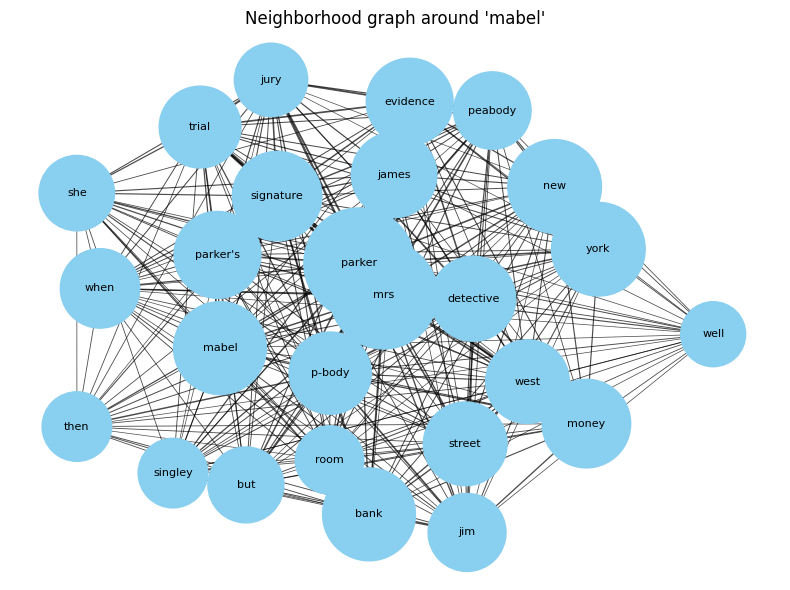

Saved: top_degree_nodes.csv and nearest_examples.csv and ego_mabel.png


In [6]:
print("Nearest to 'crime':", nearest("crime", k=10)[:5])
print("Nearest to 'mabel':", nearest("mabel", k=10)[:5])

print("Score('couser','forgery') =", link_score("couser","forgery"))
print("Score('courts','what')    =", link_score("courts","what"))

# Save a small ego graph image
png = RESULTS / "ego_mabel.png"
draw_subgraph("mabel", k=25, filename=str(png))

# CSVs for the report
# Top-degree nodes
deg_df = pd.DataFrame(
    sorted(((n, G.degree(n)) for n in G.nodes()), key=lambda x: -x[1])[:25],
    columns=["node","degree"]
)
deg_csv = RESULTS / "top_degree_nodes.csv"
deg_df.to_csv(deg_csv, index=False)

# Top neighbors of a few anchors
anchors = ["crime","mabel","court"] if "court" in idx else ["crime","mabel"]
rows = []
for a in anchors:
    for n, s in nearest(a, k=15):
        rows.append({"anchor": a, "neighbor": n, "sim": s})
nn_csv = RESULTS / "nearest_examples.csv"
pd.DataFrame(rows).to_csv(nn_csv, index=False)

print("Saved:", deg_csv.name, "and", nn_csv.name, "and", png.name)

## 6️⃣ Export Embeddings for Streamlit App

Caches `embeddings.npy` and `nodes.npy` in `models/` for fast loading by `ui/app.py`.

In [7]:
np.save(MODELS_DIR / "embeddings.npy", Z)
np.save(MODELS_DIR / "nodes.npy", np.array(nodes))
print("Saved embeddings.npy and nodes.npy to models/")

Saved embeddings.npy and nodes.npy to models/


## ✅ Summary

- Rebuilt graph identically to training.  
- Loaded GraphSAGE with consistent hidden = 64 and matching feature layout.  
- Generated embeddings and interactive utilities (nearest, link score, subgraph).  
- Saved PNG/CSV artifacts and cached arrays for the Streamlit interface.  
Next: integrate these utilities into `ui/app.py` for browser-based exploration.